In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPOCHS = 10
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "/kaggle/input/crop-pest-and-disease-detection"
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MAX_IMAGES_PER_CATEGORY = 5000
CLASS_NAMES = ['Cashew', 'Cassava', 'Maize', 'Tomato']

### Helper Functions for Processing Data

In [3]:
"""
    Get the disease category from the file path
    
    @param file_path - the path to the image file
    @returns the category of the disease
"""
def get_disease_category_by_path(file_path):
    return file_path.split("/")[4]

"""
    Get the plant category from the file path
    
    @param file_path - the path to the image file
    @returns the category of the plant
"""
def get_plant_category_by_path(file_path):
  disease_category = get_disease_category_by_path(file_path)
  return disease_category.split(" ")[0]

In [4]:
"""
    Convert a dataset of images to tensors
    
    @param images - the list of images to convert
    @returns a list of images as tensors
"""
def process_images(images):
  image_list = []

  for filename in images:
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    image_list.append(img)

  return image_list

In [5]:
"""
    Remove invalid images from dataframe
    
    @param df - dataframe containing image filenames
    @returns a dataframe with only valid images in the filename col
"""
def clean_image_dataframe(df):
  for image in df['filename']:
    try:
      img = tf.io.read_file(image)
      img = tf.io.decode_jpeg(img)
    except:
      index = df[(df.filename == image)].index
      df = df.drop(index)
  return df

In [6]:
"""
    Encode the target label
    
    @param label - the target label to be encoded
    @return a encoded label
"""
def encode_label(label):
  if label == 'Cashew':
    return 0
  elif label == 'Cassava':
    return 1
  elif label == 'Maize':
    return 2
  elif label == 'Tomato':
    return 3
  else:
    return -1

### Perform EDA (Exploratory Data Analysis)

In [7]:
filenames = []
plant_category = []
disease_category = []

# sort the categories and filenames into lists
for (root, dirs, files) in os.walk(DATASET_DIR):
  for filename in files:
    fn = str(root + "/" + filename)
    filenames.append(fn)

    pc = get_plant_category_by_path(fn)
    plant_category.append(pc)

    dc = get_disease_category_by_path(fn)
    disease_category.append(dc)

In [8]:
# create a Pandas dataframe using the lists
data = { "filename": filenames, "plant category": plant_category, "disease category": disease_category }
df = pd.DataFrame(data)
df = df.sample(frac=1)  # shuffle the dataframe

print(df.head(10))

                                                filename plant category  \
10904  /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
1459   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
25082  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
8170   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
2172   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
5797   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
10037  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
13421  /kaggle/input/crop-pest-and-disease-detection/...         Tomato   
20406  /kaggle/input/crop-pest-and-disease-detection/...         Tomato   
3017   /kaggle/input/crop-pest-and-disease-detection/...         Cashew   

                disease category  
10904            Cassava healthy  
1459          Cassava green mite  
25082        Maize fall armyworm  
8170    Cassava bacterial blight  

In [9]:
# remove invalid images from the dataframe
df = clean_image_dataframe(df)
print(f"Length of DF: {len(df['filename'])}")

Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x94
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a
Corrupt JPEG data: 8635 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x2e
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x56
Corrupt JPEG data: premature end of data segment
Unsupported JPEG process: SOF type 0xcb
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x58
Corrupt JPEG data: 592 extraneous bytes before marker 0xdb
Bogus DQT index 6
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x99
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x14
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x06
Invalid JPEG file structure: SOS before SOF
Corrupt JPEG data: premature end of data segment
Unsupported marker type

Length of DF: 25124


In [10]:
category_sizes = df.groupby("plant category").size()
print(category_sizes)

plant category
Cashew     6549
Cassava    7508
Maize      5288
Tomato     5779
dtype: int64


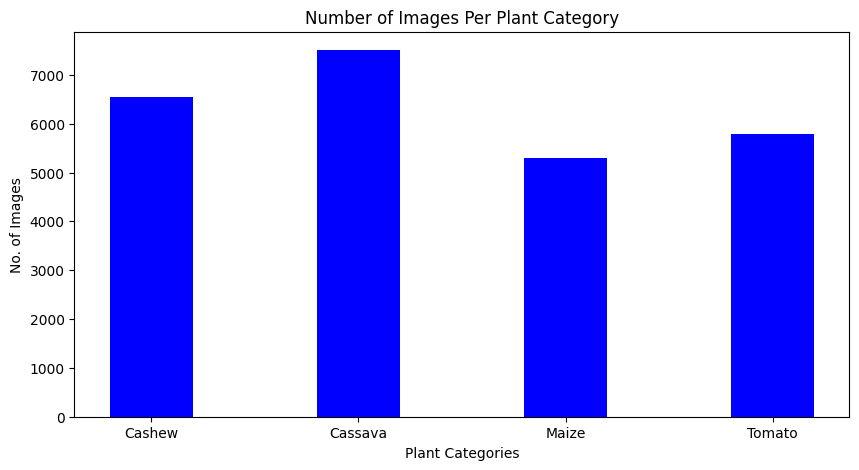

In [11]:
categories = df['plant category'].sort_values().unique()

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(categories, category_sizes, color ='blue',
        width = 0.4)

plt.xlabel("Plant Categories")
plt.ylabel("No. of Images")
plt.title("Number of Images Per Plant Category")
plt.show()

### Create a Balanced Training Dataset and Validation Dataset

We have an unbalanced set of images. There are nearly 20% more Cassava images than Maize images. Let's use only 5000 images from each category to create the training and validation datasets.
We can use the remaining images to create a test dataset for evaluating the model after training.

In [12]:
# truncate the number of images in each category so each have an equal amount
cashew_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cashew' == x][0:MAX_IMAGES_PER_CATEGORY]
cassava_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cassava' == x][0:MAX_IMAGES_PER_CATEGORY]
maize_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Maize' == x][0:MAX_IMAGES_PER_CATEGORY]
tomato_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Tomato' == x][0:MAX_IMAGES_PER_CATEGORY]

dataset = []

def create_dataset(filenames, label):
  for filename in filenames:
    data_subset = []
    data_subset.append(filename)
    data_subset.append(encode_label(label))

    dataset.append(data_subset)

create_dataset(cashew_files, 'Cashew')
create_dataset(cassava_files, 'Cassava')
create_dataset(maize_files, 'Maize')
create_dataset(tomato_files, 'Tomato')

unbalanced_dataset_size = len(df['filename'].unique())
balanced_dataset_size = len(dataset)
loss = round((1 - (balanced_dataset_size / unbalanced_dataset_size)) * 100, 2)

print(f"Size of Unbalanced Dataset: {unbalanced_dataset_size}")
print(f"Size of Balanced Dataset: {balanced_dataset_size}")

Size of Unbalanced Dataset: 25124
Size of Balanced Dataset: 20000


In [13]:
dataset_df = pd.DataFrame(dataset, columns=['filename', 'label'])
print(dataset_df.head())

                                            filename  label
0  /kaggle/input/crop-pest-and-disease-detection/...      0
1  /kaggle/input/crop-pest-and-disease-detection/...      0
2  /kaggle/input/crop-pest-and-disease-detection/...      0
3  /kaggle/input/crop-pest-and-disease-detection/...      0
4  /kaggle/input/crop-pest-and-disease-detection/...      0


In [14]:
X = dataset_df['filename']
y = dataset_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [15]:
X_train = process_images(X_train)
X_test = process_images(X_test)

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((X_train, y_train))
validation_ds = tf.data.Dataset.zip((X_test, y_test))

In [17]:
train_ds = train_ds.cache().shuffle(buffer_size=1024).prefetch(buffer_size=tf.data.AUTOTUNE).batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)

### Visualize a Subset of the Training Dataset

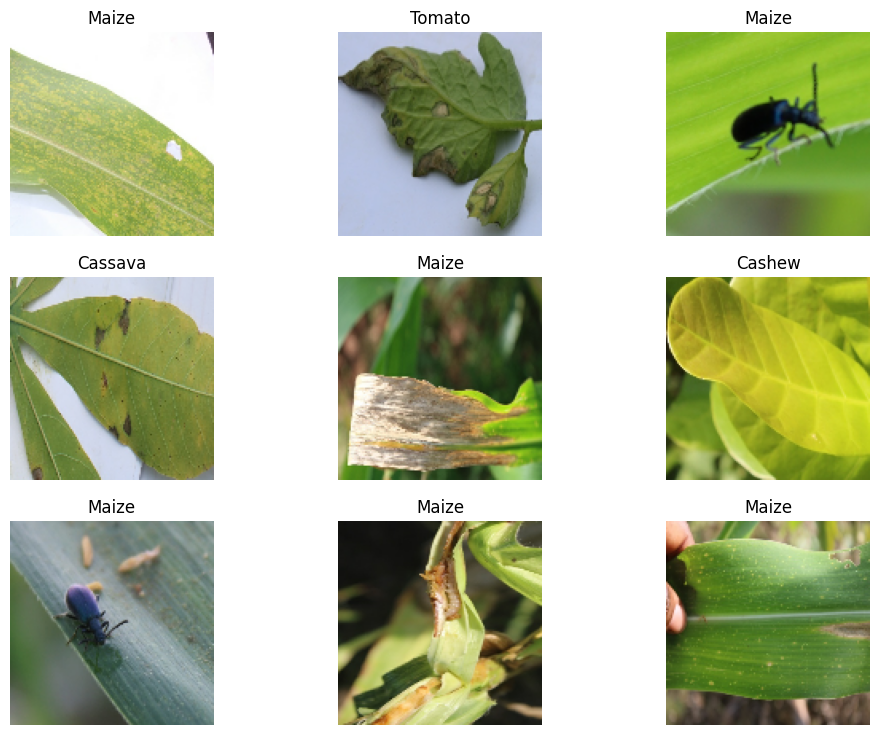

In [18]:
plt.figure(figsize=(12,9))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

#### Generate a Test Dataset from Remaining Images After Truncation

In [19]:
# Take the remaining images and create a test set that won't be seen during training
STARTING_POINT = MAX_IMAGES_PER_CATEGORY + 1
cashew_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cashew' == x][STARTING_POINT:]
cassava_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cassava' == x][STARTING_POINT:]
maize_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Maize' == x][STARTING_POINT:]
tomato_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Tomato' == x][STARTING_POINT:]

test_dataset = []

def create_test_dataset(filenames, label):
  for filename in filenames:
    data_subset = []
    data_subset.append(filename)
    data_subset.append(encode_label(label))

    test_dataset.append(data_subset)

create_test_dataset(cashew_files, 'Cashew')
create_test_dataset(cassava_files, 'Cassava')
create_test_dataset(maize_files, 'Maize')
create_test_dataset(tomato_files, 'Tomato')

test_dataset_size = len(test_dataset)
print(f"Size of Test Dataset: {test_dataset_size}")

test_dataset_df = pd.DataFrame(test_dataset, columns=['filename', 'label'])
print(test_dataset_df.head())

test_images = process_images(test_dataset_df['filename'])
test_labels = test_dataset_df['label']

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE)

Size of Test Dataset: 5120
                                            filename  label
0  /kaggle/input/crop-pest-and-disease-detection/...      0
1  /kaggle/input/crop-pest-and-disease-detection/...      0
2  /kaggle/input/crop-pest-and-disease-detection/...      0
3  /kaggle/input/crop-pest-and-disease-detection/...      0
4  /kaggle/input/crop-pest-and-disease-detection/...      0


In [20]:
base_model = tf.keras.applications.VGG16(
    include_top = False,
    input_shape=INPUT_SHAPE,
    weights="imagenet"
)
base_model.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [23]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

Epoch 1/10
235/235 [==============================] - 21s 70ms/step - loss: 5.0406 - accuracy: 0.6479 - val_loss: 3.1696 - val_accuracy: 0.8108
Epoch 2/10
235/235 [==============================] - 14s 60ms/step - loss: 2.2907 - accuracy: 0.7691 - val_loss: 2.4331 - val_accuracy: 0.8452
Epoch 3/10
235/235 [==============================] - 14s 61ms/step - loss: 1.8276 - accuracy: 0.7935 - val_loss: 2.3565 - val_accuracy: 0.8428
Epoch 4/10
235/235 [==============================] - 14s 60ms/step - loss: 1.7338 - accuracy: 0.7968 - val_loss: 3.0438 - val_accuracy: 0.8214
Epoch 5/10
235/235 [==============================] - 14s 61ms/step - loss: 1.8262 - accuracy: 0.7987 - val_loss: 2.2818 - val_accuracy: 0.8320
Epoch 6/10
235/235 [==============================] - 14s 61ms/step - loss: 2.1216 - accuracy: 0.7923 - val_loss: 2.6806 - val_accuracy: 0.8616
Epoch 7/10
235/235 [==============================] - 14s 61ms/step - loss: 1.5602 - accuracy: 0.8045 - val_loss: 2.6779 - val_accuracy:

### **Classification Report**

In [24]:
print(model.evaluate(test_ds, return_dict=True))

80/80 [==============================] - 4s 44ms/step - loss: 0.9515 - accuracy: 0.8408
{'loss': 0.9515311121940613, 'accuracy': 0.8408203125}


Text(0.5, 0, 'Epoch')

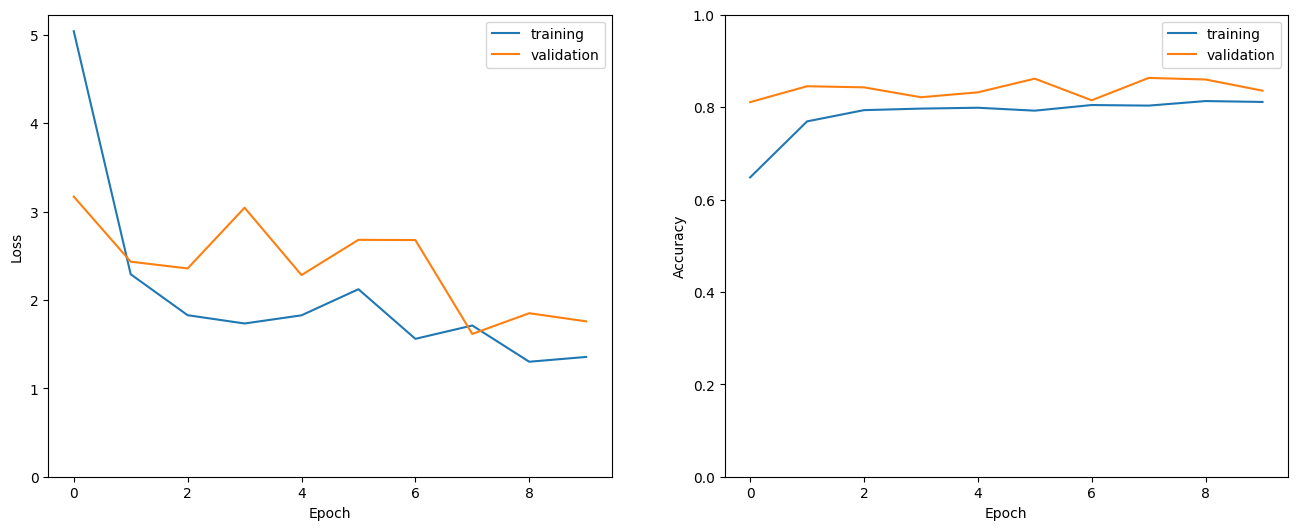

In [25]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [26]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

80/80 [==============================] - 3s 42ms/step


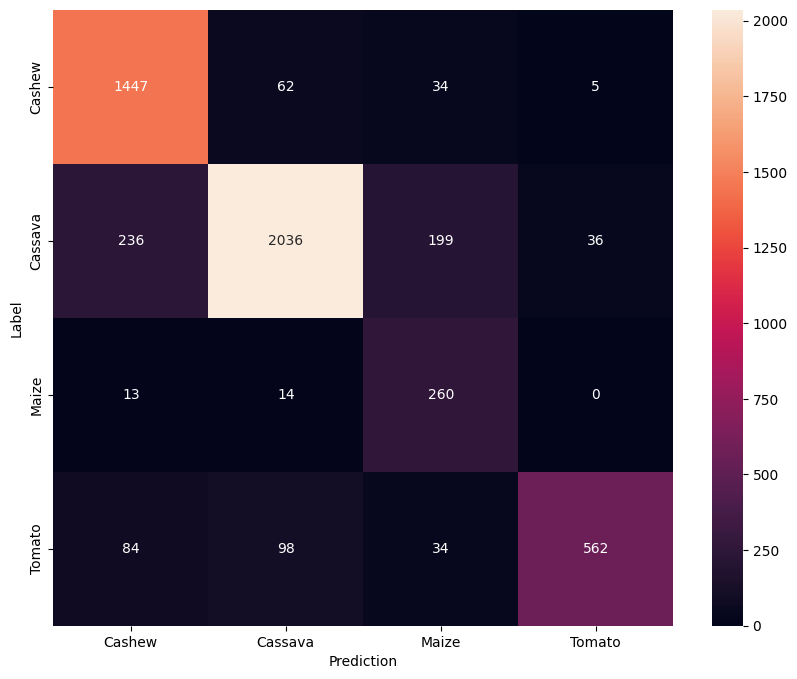

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
print(y_pred)

[0 0 0 ... 1 0 0]


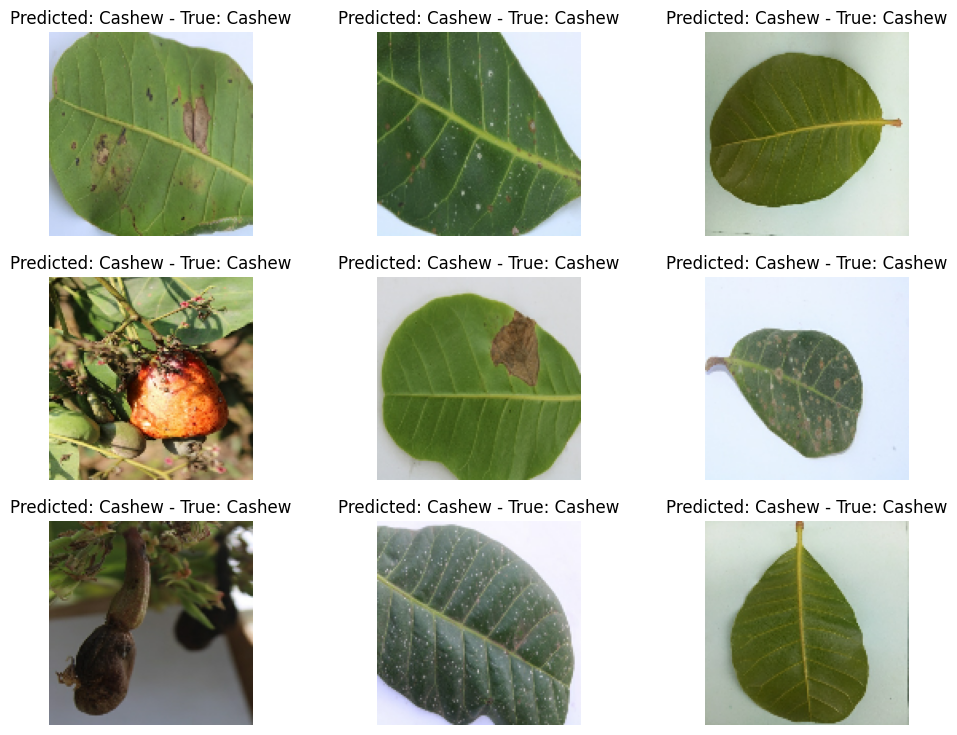

In [29]:
plt.figure(figsize=(12,9))
for image, label in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {CLASS_NAMES[y_pred[i]]} - True: {CLASS_NAMES[y_true[i]]}")
    plt.axis("off")